In [8]:
from langchain_qdrant import QdrantVectorStore, FastEmbedSparse
from qdrant_client import QdrantClient
from dotenv import load_dotenv
import os
from langchain_huggingface import HuggingFaceEmbeddings

from langchain_community.tools import WikipediaQueryRun
from langchain_tavily import TavilySearch
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_tavily import TavilySearch
from langchain_core.tools import Tool
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain.agents import create_agent
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


from dataclasses import dataclass
from pydantic import BaseModel, Field
# from typing import List
from langchain_core.documents import Document

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph_supervisor import create_supervisor
from IPython.display import display, Image
from typing import List, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from pprint import pprint
load_dotenv()

from langgraph.checkpoint.memory import MemorySaver


In [9]:
class ProcessLoader:

    def __init__(self):
        self.client = QdrantClient(
                            url=os.getenv('QDRANT_API_URL'),
                            api_key=os.getenv('QDRANT_API_KEY')
                        )
        self.dense_embedding = HuggingFaceEmbeddings(model = 'sentence-transformers/all-MiniLM-L12-v2')
        self.sparse_embedding = FastEmbedSparse(model_name ='Qdrant/bm25')
        
        self.qdrantdb = QdrantVectorStore(
            client=self.client,
            collection_name= os.getenv('COLLECTIONNAME'),
            embedding=self.dense_embedding,
            sparse_embedding=self.sparse_embedding
        )
        self.wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results= 5, doc_content_chars_max= 2000))
        self.tavily_tool = TavilySearch(
            max_results=5,
            topic="general",
        )

    @property
    def getPBIRetriver(self):

        return self.qdrantdb.as_retriever(
            search_type = 'mmr',
                search_kwarg = {
                    "k":10
                }
        )
    
    @property
    def wikiTool(self):
        return self.wiki_tool
    
    @property
    def tavilyTool(self):
        return self.tavily_tool
    
    @property
    def getllm(self):
        return ChatGroq(model='openai/gpt-oss-120b')
    
    


In [10]:
obj = ProcessLoader()
pbiretriever = obj.getPBIRetriver

def powerBITool(query: str) -> str:
    
    result = pbiretriever.invoke(query)
    return '\n\n'.join([doc.page_content for doc in result])

    

pbitool = Tool(
    func= powerBITool,
    name="PBI_Triver",
    description= "Tool is created to retrive Power BI docs from Qdrant"
    
)

In [11]:

llm_base = obj.getllm
wikitool = obj.wikiTool
tavilytool = obj.tavilyTool
tools = [wikitool, tavilytool, pbitool]

In [12]:
def getPrompt(promptInstruction : str) -> str:

    return f""" 
                ### 📝 GENERIC RESEARCH MANDATE ###

                    **PRIMARY TOPIC:** Based on User Query Topic should be taken

                    **RESEARCH OBJECTIVE:**
                    You are an expert, objective research analyst. Your task is to produce a comprehensive, multi-faceted report on the **PRIMARY TOPIC** that achieves a deep understanding of its current state, challenges, and future trajectory.

                    ---

                    ### 🔍 RESEARCH SCOPE & CONSTRAINTS ###
                    * **Timeframe:** Focus primarily on developments and data from the last **5 years** (e.g., 2020–present), unless historical context is strictly necessary to understand the current state.
                    * **Depth:** Research must move beyond Wikipedia-level summaries and include synthesis, analysis, and critical evaluation of information.
                    * **Exclusions:** Avoid pure dictionary definitions or tangential subjects. Focus exclusively on the topic's direct implications.

                    ---

                    ### 🔑 MANDATORY REPORT SECTIONS ###

                    The final output MUST be organized into the following four distinct sections.

                    **SECTION 1: Overview & Current State**
                    * **Goal:** Define the topic and establish its importance.
                    * **Content:** Provide a concise, professional definition. Detail the topic's current scale, major players, or widely accepted status quo.

                    **SECTION 2: Key Challenges & Controversies**
                    * **Goal:** Identify and analyze critical obstacles.
                    * **Content:** Identify and analyze the **three most significant challenges** or **major points of controversy** surrounding the topic. For each challenge, explain the nature of the problem and its primary contributing factors.

                    **SECTION 3: Emerging Trends & Future Trajectory**
                    * **Goal:** Forecast and highlight new developments.
                    * **Content:** Identify and analyze **two major emerging trends** or **potential future applications/solutions** that are likely to shape the topic over the next 5–10 years.

                    **SECTION 4: Conclusion & Strategic Implications**
                    * **Goal:** Summarize findings and provide actionable takeaways.
                    * **Content:** Summarize the main analytical findings. Answer this critical question: **"What is the single most important strategic implication for an organization or individual engaging with this topic?"**

                    ---

                    ### ✨ OUTPUT FORMATTING RULES ###
                    1.  **Tone:** Maintain an **analytical, objective, and professional** tone throughout.
                    2.  **Citations (Fictional):** For each of the three mandatory challenges and two emerging trends, invent and list a realistic-sounding **source type** (e.g., "[Source: 2024 Market Analysis Report]", "[Source: Nature Communications Paper, 2023]"). This simulates a research process and improves analytical depth.
                    3.  **Formatting:** Use markdown headings and bolding to clearly delineate the four sections and their sub-points.

                    NOTE: {promptInstruction}
                """

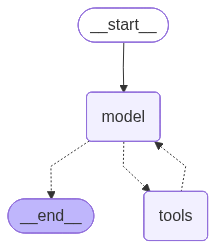

In [13]:
agent = create_agent(
    llm_base,
    tools=tools,
    name="PBIAgent",
    system_prompt=getPrompt("You can only do research. Use the tool that you are binded with, you can use both of them" \
                " You are working with a content writer colleague."),
    checkpointer= MemorySaver()    
)
agent

In [14]:
from uuid import uuid4

config = {
    "configurable": {
        "thread_id": uuid4()
    }
}

In [ ]:
result = agent.invoke({"messages" : "What is the Difference between DAX and M Query"}, config=config)
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

What is the Difference between DAX and M Query
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_b75613da-1137-4ecb-90bb-1390fcac859b)
 Call ID: fc_b75613da-1137-4ecb-90bb-1390fcac859b
  Args:
    query: DAX vs M query differences 2023 2024 Power BI
    search_depth: advanced
    time_range: year
================================= Tool Message =================================
Name: tavily_search

{"query": "DAX vs M query differences 2023 2024 Power BI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.crossjoin.co.uk/2025/01/26/why-dax-is-better-than-mdx-for-bulk-extracts-of-data-from-power-bi/", "title": "Why DAX is better than MDX for bulk extracts of data from Power BI", "content": "Writing a DAX query to get granular data is usually a lot simpler than writing an MDX query\n DAX queries that retu

In [ ]:
result = agent.invoke({"messages" : "What is the Difference Power BI Desktop and Paginated Report"}, config=config)
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

What is the Difference between DAX and M Query
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_b75613da-1137-4ecb-90bb-1390fcac859b)
 Call ID: fc_b75613da-1137-4ecb-90bb-1390fcac859b
  Args:
    query: DAX vs M query differences 2023 2024 Power BI
    search_depth: advanced
    time_range: year
================================= Tool Message =================================
Name: tavily_search

{"query": "DAX vs M query differences 2023 2024 Power BI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.crossjoin.co.uk/2025/01/26/why-dax-is-better-than-mdx-for-bulk-extracts-of-data-from-power-bi/", "title": "Why DAX is better than MDX for bulk extracts of data from Power BI", "content": "Writing a DAX query to get granular data is usually a lot simpler than writing an MDX query\n DAX queries that retu

In [17]:
result = agent.invoke({"messages" : "What is Power BI?"}, config=config)
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

What is the Difference between DAX and M Query
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_b75613da-1137-4ecb-90bb-1390fcac859b)
 Call ID: fc_b75613da-1137-4ecb-90bb-1390fcac859b
  Args:
    query: DAX vs M query differences 2023 2024 Power BI
    search_depth: advanced
    time_range: year
================================= Tool Message =================================
Name: tavily_search

{"query": "DAX vs M query differences 2023 2024 Power BI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.crossjoin.co.uk/2025/01/26/why-dax-is-better-than-mdx-for-bulk-extracts-of-data-from-power-bi/", "title": "Why DAX is better than MDX for bulk extracts of data from Power BI", "content": "Writing a DAX query to get granular data is usually a lot simpler than writing an MDX query\n DAX queries that retu

In [18]:
chat_history = agent.get_state(config=config).values['messages']
for item in chat_history:
    item.pretty_print()

================================ Human Message =================================

What is the Difference between DAX and M Query
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_b75613da-1137-4ecb-90bb-1390fcac859b)
 Call ID: fc_b75613da-1137-4ecb-90bb-1390fcac859b
  Args:
    query: DAX vs M query differences 2023 2024 Power BI
    search_depth: advanced
    time_range: year
================================= Tool Message =================================
Name: tavily_search

{"query": "DAX vs M query differences 2023 2024 Power BI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.crossjoin.co.uk/2025/01/26/why-dax-is-better-than-mdx-for-bulk-extracts-of-data-from-power-bi/", "title": "Why DAX is better than MDX for bulk extracts of data from Power BI", "content": "Writing a DAX query to get granular data is usually a lot simpler than writing an MDX query\n DAX queries that retu